In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import math
from pprint import pprint
import seaborn as sns
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.stats import kstest, ks_2samp
%matplotlib inline

In [2]:
def match(catalog_1, catalog_2):
    """
    匹配两个表
    :param catalog_1:
    :param catalog_2:
    :return:
    """
    sdss = SkyCoord(ra=catalog_1.ra*u.degree, dec=catalog_1.dec*u.degree)
    decals = SkyCoord(ra=catalog_2.ra*u.degree, dec=catalog_2.dec*u.degree)
    idx, d2d, d3d = sdss.match_to_catalog_sky(decals)
    max_sep = 4 * 0.262 * u.arcsec
    distance_idx = d2d < max_sep
    sdss_matches = catalog_1.iloc[distance_idx]
    matches = idx[distance_idx]
    decal_matches = catalog_2.iloc[matches]
    test = sdss_matches.loc[:].rename(columns={"ra":"new_ra", "dec":"new_dec"})
    test.insert(0, 'ID', range(len(test)))
    decal_matches.insert(0, 'ID', range(len(decal_matches)))
    new_df = pd.merge(test, decal_matches, how="inner", on=["ID"])
    return new_df.drop("ID", axis=1)

def calculate_percent(df: pd.DataFrame=None, num=None):
    """返回占比"""
    sum = 0
    if num == None:
        num = [len(df.query("label == 0 or label == '0'")),len(df.query("label == 1 or label == '1'")),
                   len(df.query("label == 2 or label == '2'")),len(df.query("label == 3 or label == '3'")),
                   len(df.query("label == 4 or label == '4'")),len(df.query("label == 5 or label == '5'")),
                   len(df.query("label == 6 or label == '6'"))]
    for i in num:
        sum += i
    return [x/sum for x in num]

In [3]:
f = fits.open("/data/GZ_Decals/MGS_out_DECaLS.fits")

In [4]:
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200 / length of dimension 1                          
NAXIS2  =               476890 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'VID     '                                                            
TFORM1  = 'J       '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'DEC     '        

In [5]:
"""out_DECaLS"""
with fits.open("/data/GZ_Decals/MGS_out_DECaLS.fits") as hdul:
    ra = np.array(hdul[1].data["RA      "])
    dec = np.array(hdul[1].data["DEC     "])
    petro_mag = np.array(hdul[1].data["PETROMAG"][:, 2])
    z = np.array(hdul[1].data["Z       "])
    out_decals_origion = pd.DataFrame(np.array((ra, dec, petro_mag, z)).T, columns=["ra", "dec", "petro_mag", "redshift"])

In [6]:
out_decals_origion

,ra,dec,petro_mag,redshift
0,341.101481,1.266255,17.587046,0.143369
1,341.098882,1.266247,17.136894,0.000000
2,49.248945,1.272430,17.535475,0.110611
3,49.917850,1.265957,17.175228,0.000000
4,50.234796,1.271943,17.302996,0.074298
...,...,...,...,...
476885,162.049615,10.021595,17.095675,0.170325
476886,162.154275,9.985978,17.436974,0.063593
476887,162.249397,9.950054,17.436905,0.221310
476888,162.617135,9.930693,17.356991,0.166742


In [7]:
"""主星系, 74w个样本，最原始的catalog"""
with fits.open("/data/GZ_Decals/VAGC_MGS-m14_1777--20180116.fits") as hdul:
    ra = np.array(hdul[1].data["RA      "])
    dec = np.array(hdul[1].data["DEC     "])
    petro_mag = np.array(hdul[1].data["PETROMAG"][:, 2])
    z = np.array(hdul[1].data["Z       "])
    MGS = pd.DataFrame(np.array((ra, dec, petro_mag, z)).T, columns=["ra", "dec", "petro_mag", "redshift"])

In [8]:
MGS

,ra,dec,petro_mag,redshift
0,337.450310,1.266134,16.952042,0.088372
1,338.114079,1.271937,17.300024,0.165530
2,338.115522,1.270146,17.517248,0.163800
3,341.101481,1.266255,17.587046,0.143369
4,341.098882,1.266247,17.136894,0.000000
...,...,...,...,...
746945,162.179214,10.066991,16.888079,0.033458
746946,162.439221,9.985815,17.519909,0.127600
746947,162.617135,9.930693,17.356991,0.166742
746948,162.644268,9.942940,17.213787,0.037024


In [9]:
"""训练验证测试集"""
decals_dataset = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)
"""decals的测试集结果"""
decals_pred = pd.read_csv("/data/renhaoye/decals_2022/decals_test_prob.csv", index_col=0)
"""sdss的预测结果"""
sdss_pred = pd.read_csv("/data/renhaoye/decals_2022/sdss_test_prob.csv", index_col=0)
"""非DECaLS天区预测结果"""
out_decals_pred = pd.read_table("/data/renhaoye/decals_2022/out_decals_prob.txt", sep="\s+")
labels = ["merger", "round", "between", "cigar", "edgeOn", "noBar", "strongBar"]

In [10]:
overlap = match(decals_dataset, out_decals_origion)

In [11]:
overlap

,new_ra,new_dec,redshift_x,iauname,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,mag_r,label,func,ra,dec,petro_mag,redshift_y


In [12]:
decals_dataset

,ra,dec,redshift,iauname,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,mag_r,label,func
280684,228.253553,17.001007,0.128372,J151300.84+170003.6,6.974970,3.530749,8.043182,-21.397460,16.741436,0,train
308571,18.403378,1.242624,0.120664,J011336.81+011433.4,5.357219,2.873933,7.314268,-21.831284,16.062775,0,train
268979,356.932802,-2.610917,0.030901,J234744.50-023646.9,15.164274,5.864809,18.633486,-19.064878,15.318168,0,train
296601,215.997519,-0.890637,0.133594,J142359.39-005326.2,10.527441,4.224710,14.072979,-22.040115,16.286236,0,train
174192,155.049169,14.096121,0.146089,J102011.79+140546.1,9.513814,5.177910,12.710546,-22.378520,15.564474,0,train
...,...,...,...,...,...,...,...,...,...,...,...
219841,24.653104,-4.682799,0.048784,J013836.69-044058.0,17.698072,7.415717,20.187800,-21.068200,14.825631,6,valid
110592,243.579343,30.214586,0.094828,J161419.04+301252.5,7.391881,3.314074,8.751869,-21.017754,16.270058,6,valid
152632,17.974347,-4.618883,0.053374,J011153.89-043708.0,11.637828,5.300970,11.823557,-20.770077,15.467412,6,valid
25118,32.648135,-0.937623,0.068009,J021035.54-005615.3,12.270542,5.666851,12.626719,-21.048773,15.494813,6,valid


In [13]:
decals_pred

,ra,dec,redshift,iauname,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,mag_r,label,func,prob,pred
229870,136.555319,14.614740,0.111484,J090613.25+143653.1,5.152971,2.426346,5.103452,-17.659460,19.887907,0,test,0.877540,0
41748,228.096530,15.849218,0.089470,J151223.35+155058.9,6.243227,3.644343,8.128530,-20.868366,16.485563,0,test,0.932280,0
89030,145.891597,29.276509,0.111800,J094333.98+291635.4,11.856368,5.666851,19.506390,-22.501337,15.691400,0,test,0.795840,2
64676,216.091102,9.976289,0.079640,J142422.01+095833.2,7.718815,4.043024,8.220333,-21.469368,15.613243,0,test,0.642235,0
109595,163.240849,4.516879,0.118492,J105257.79+043100.8,9.606126,3.728810,12.958405,-21.144205,16.956852,0,test,0.828204,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116305,217.958394,-0.946793,0.121901,J143150.01-005648.3,9.881393,3.663627,10.362074,-21.491684,16.293407,6,test,0.848606,0
108335,232.985845,9.442847,0.033548,J153156.60+092634.1,8.844737,4.695026,9.829379,-18.833164,16.121803,6,test,0.990099,6
266171,216.834853,1.025850,0.025656,J142720.36+010133.0,43.075893,19.141302,52.852530,-21.506033,12.638571,6,test,0.999233,6
78697,210.742658,18.768494,0.110733,J140258.23+184606.5,9.624050,3.801506,9.829379,-21.531315,16.212310,6,test,0.997851,6


In [14]:
print(len(decals_dataset), len(decals_pred), len(sdss_pred), len(out_decals_pred))

123954 12398 8431 457118


In [15]:
out_decals_pred = match(MGS, out_decals_pred) # 非DECaLS天区预测结果与母表匹配
out_decals_pred.drop(["new_ra", "new_dec"], axis=1, inplace=True)

In [16]:
out_decals_pred

,petro_mag,redshift,ra,dec,loc,label,prob
0,17.587046,0.143369,341.101481,1.266255,341.1014809262565_1.2662548842245596_0.262_grz...,0,0.927533
1,17.136894,0.000000,341.098882,1.266247,341.09888228646247_1.2662474191430217_0.262_gr...,0,0.860787
2,17.535475,0.110611,49.248945,1.272430,49.24894472536414_1.2724302971589245_0.262_grz...,4,0.876171
3,17.175228,0.000000,49.917850,1.265957,49.917849887022726_1.2659570046932_0.262_grz_....,1,0.750806
4,17.302996,0.074298,50.234796,1.271943,50.23479595044978_1.2719425874594474_0.262_grz...,2,0.907829
...,...,...,...,...,...,...,...
457114,17.095675,0.170325,162.049615,10.021595,162.04961468858818_10.021594583432893_0.262_gr...,5,0.583965
457115,17.436974,0.063593,162.154275,9.985978,162.1542746876599_9.985978233361172_0.262_grz_...,3,0.987632
457116,17.436905,0.221310,162.249397,9.950054,162.24939744762875_9.95005411419437_0.262_grz_...,2,0.973237
457117,17.356991,0.166742,162.617135,9.930693,162.6171345118246_9.930693210090007_0.262_grz_...,5,0.972327


In [17]:
"""得到原始的分布并与母表匹配"""
decals_df = pd.read_csv("/data/renhaoye/decals_2022/fits.csv", index_col=0)
threshold = 0.5
merger = decals_df.query('merging_minor_disturbance_fraction > %f '
                           '| merging_major_disturbance_fraction > %f '
                           '| merging_merger_fraction > %f ' % (threshold, threshold, threshold))
round = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                              '& how_rounded_round_fraction > %f' % (threshold, threshold))
between = decals_df.query('smooth_or_featured_smooth_fraction >  %f '
                                '& how_rounded_in_between_fraction > %f' % (threshold, threshold))
cigar = decals_df.query('smooth_or_featured_smooth_fraction > %f '
                                  '& how_rounded_cigar_shaped_fraction > %f' % (threshold, threshold))
edgeOn = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                       '& disk_edge_on_yes_fraction > %f' % (threshold, threshold))
noBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                          '& disk_edge_on_no_fraction > %f '
                          '& bar_no_fraction > %f ' % (threshold, threshold, threshold))
strongBar = decals_df.query('smooth_or_featured_featured_or_disk_fraction > %f '
                              '& disk_edge_on_no_fraction > %f '
                              '&bar_strong_fraction > %f ' % (threshold, threshold, threshold))
merger.insert(0, "label", 0)
round.insert(0, "label", 1)
between.insert(0, "label", 2)
cigar.insert(0, "label", 3)
edgeOn.insert(0, "label", 4)
noBar.insert(0, "label", 5)
strongBar.insert(0, "label", 6)
decals_50p = match(MGS, pd.concat([merger, round, between, cigar, edgeOn, noBar, strongBar]))

In [18]:
def find_max(a):
    idx = a.argmax(axis=1)
    out = np.zeros_like(a,dtype=float)
    out[np.arange(a.shape[0]), idx] = 1
    return out
decals_df_d = decals_df.drop(["iauname", "petro_theta", "petro_th50", "petro_th90",
                              "elpetro_absmag_r", "sersic_nmgy_r", "mag_r", "smooth_or_featured_smooth_concentration",
                              'smooth_or_featured_featured_or_disk_concentration',
                              "disk_edge_on_no_concentration", "disk_edge_on_yes_concentration",
                              'has_spiral_arms_yes_concentration', "has_spiral_arms_no_concentration",
                              "bar_no_concentration", "bar_weak_concentration",
                              "bar_strong_concentration", 'bulge_size_none_concentration',
                              "bulge_size_small_concentration", "bulge_size_dominant_concentration",
                              "bulge_size_large_concentration", "bulge_size_moderate_concentration",
                              "how_rounded_round_concentration",
                              "how_rounded_cigar_shaped_concentration",
                              "how_rounded_in_between_concentration",
                              "edge_on_bulge_none_concentration",
                              "edge_on_bulge_rounded_concentration",
                              "edge_on_bulge_boxy_concentration",
                              "spiral_winding_loose_concentration",
                              "spiral_winding_medium_concentration",
                              "spiral_winding_tight_concentration",
                              "spiral_arm_count_1_concentration", "spiral_arm_count_2_concentration",
                              "spiral_arm_count_3_concentration", "spiral_arm_count_4_concentration",
                              "spiral_arm_count_cant_tell_concentration",
                              "spiral_arm_count_more_than_4_concentration",
                              "merging_none_concentration", "merging_merger_concentration",
                              "merging_major_disturbance_concentration",
                              "merging_minor_disturbance_concentration",
                              "smooth_or_featured_artifact_concentration",
                              "file_loc", "wrong_size_statistic", "wrong_size_warning",
                              "merging_proportion_volunteers_asked",
                              "bar_proportion_volunteers_asked",
                              "spiral_arm_count_proportion_volunteers_asked",
                              "spiral_arm_count_proportion_volunteers_asked",
                              "disk_edge_on_proportion_volunteers_asked",
                              "edge_on_bulge_proportion_volunteers_asked",
                              "bulge_size_proportion_volunteers_asked",
                              "has_spiral_arms_proportion_volunteers_asked",
                              "how_rounded_proportion_volunteers_asked",
                              "smooth_or_featured_proportion_volunteers_asked",
                              "spiral_winding_proportion_volunteers_asked"], axis=1)
head = np.array(decals_df_d[["ra", "dec", "redshift"]])
q1 = find_max(np.array(decals_df_d[["merging_merger_fraction", "merging_major_disturbance_fraction",
                  "merging_minor_disturbance_fraction", "merging_none_fraction"]]))
q2 = find_max(np.array(decals_df_d[["smooth_or_featured_artifact_fraction",
                  "smooth_or_featured_featured_or_disk_fraction",
                  "smooth_or_featured_smooth_fraction"]]))
q3_1 = find_max(np.array(decals_df_d[["how_rounded_round_fraction", 'how_rounded_in_between_fraction',
                    "how_rounded_cigar_shaped_fraction"]]))
q3_2 = find_max(np.array(decals_df_d[["disk_edge_on_yes_fraction", "disk_edge_on_no_fraction"]]))
q4 = find_max(np.array(decals_df_d[["bar_no_fraction", "bar_strong_fraction"]]))
q = np.concatenate((head, q1, q2, q3_1, q3_2, q4), axis=1)
decals_df_max = pd.DataFrame(q,columns=["ra", "dec", "redshift","merging_merger_fraction",
                        "merging_major_disturbance_fraction",
                        "merging_minor_disturbance_fraction", "merging_none_fraction",
                        "smooth_or_featured_artifact_fraction","smooth_or_featured_featured_or_disk_fraction",
                        "smooth_or_featured_smooth_fraction","how_rounded_round_fraction",
                        'how_rounded_in_between_fraction',"how_rounded_cigar_shaped_fraction",
                        "disk_edge_on_yes_fraction", "disk_edge_on_no_fraction","bar_no_fraction",
                        "bar_strong_fraction"])

In [19]:
merger_max = decals_df_max.query('merging_none_fraction != 1')
round_max = decals_df_max.query('smooth_or_featured_smooth_fraction == 1 '
                              '& how_rounded_round_fraction == 1')
between_max = decals_df_max.query('smooth_or_featured_smooth_fraction == 1'
                                '& how_rounded_in_between_fraction == 1')
cigar_max = decals_df_max.query('smooth_or_featured_smooth_fraction == 1'
                                  '& how_rounded_cigar_shaped_fraction == 1')
edgeOn_max = decals_df_max.query('smooth_or_featured_featured_or_disk_fraction == 1'
                       '& disk_edge_on_yes_fraction == 1')
noBar_max = decals_df_max.query('smooth_or_featured_featured_or_disk_fraction == 1'
                          '& disk_edge_on_no_fraction == 1'
                          '& bar_no_fraction == 1')
strongBar_max = decals_df_max.query('smooth_or_featured_featured_or_disk_fraction == 1'
                              '& disk_edge_on_no_fraction == 1'
                              '& bar_strong_fraction == 1')
merger_max.insert(0, "label", 0)
round_max.insert(0, "label", 1)
between_max.insert(0, "label", 2)
cigar_max.insert(0, "label", 3)
edgeOn_max.insert(0, "label", 4)
noBar_max.insert(0, "label", 5)
strongBar_max.insert(0, "label", 6)
decals_max_distribution = match(MGS, pd.concat([merger_max, round_max, between_max, cigar_max, edgeOn_max, noBar_max, strongBar_max]))
decals_max_distribution.drop(["new_ra", "new_dec"], axis=1, inplace=True)

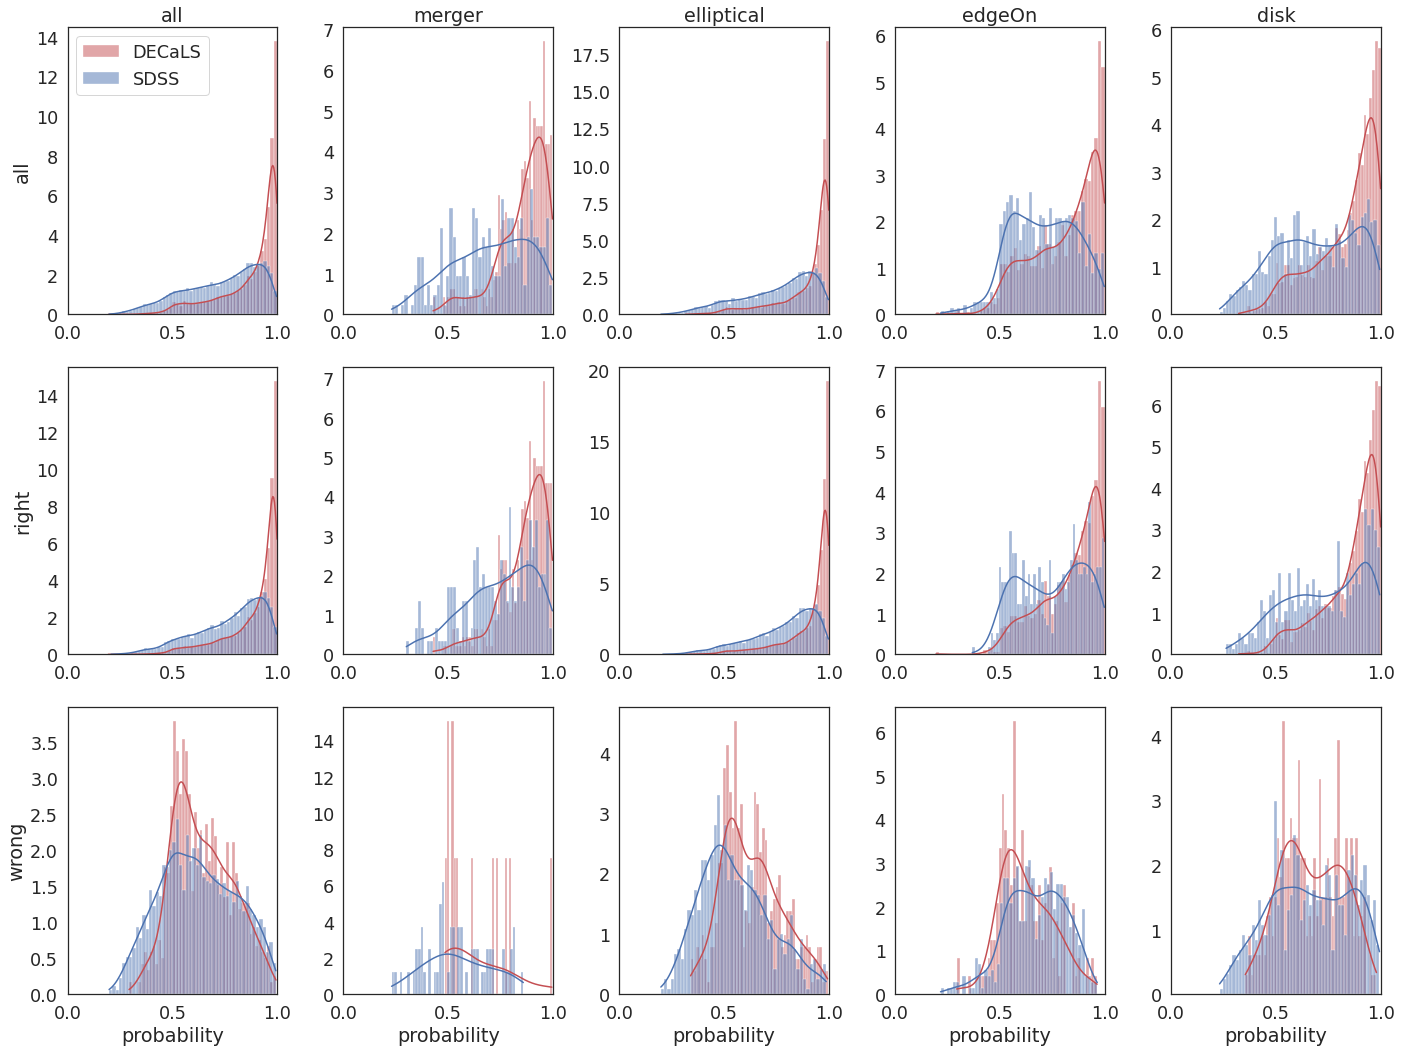

In [20]:
decals_right = decals_pred.query("label == pred")
sdss_right = sdss_pred.query("label == pred")
decals_wrong = decals_pred.query("label != pred")
sdss_wrong = sdss_pred.query("label != pred")
fig = plt.figure(figsize=(20, 15))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.6, palette=None)
sns.set_style("white")
ax = fig.add_subplot(3, 5, 1)
ax.set_title("all")
sns.histplot(decals_pred.prob,
             stat="density", label="DECaLS", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.prob,
             stat="density", label="SDSS", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel("all")
ax.legend(loc="upper left")
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 6)
sns.histplot(decals_pred.query("label == pred").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == pred").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel("right")
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 11)
sns.histplot(decals_pred.query("label != pred").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label != pred").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel("wrong")
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 2)
ax.set_title("merger")
sns.histplot(decals_pred.query("label == 0").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 0").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 7)
sns.histplot(decals_right.query("label == 0").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 0").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 12)
sns.histplot(decals_wrong.query("label == 0").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 0").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 3)
ax.set_title("elliptical")
sns.histplot(decals_pred.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 8)
sns.histplot(decals_right.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 13)
sns.histplot(decals_wrong.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 4)
ax.set_title("edgeOn")
sns.histplot(decals_pred.query("label == 4").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 4").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 9)
sns.histplot(decals_right.query("label == 4").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 4").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 14)
sns.histplot(decals_wrong.query("label == 4").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 4").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 5)
ax.set_title("disk")
sns.histplot(decals_pred.query("label == 5 or label == 6").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 5 or label == 6").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 10)
sns.histplot(decals_right.query("label == 5 or label == 6").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 5 or label == 6").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 15)
sns.histplot(decals_wrong.query("label == 5 or label == 6").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 5 or label == 6").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

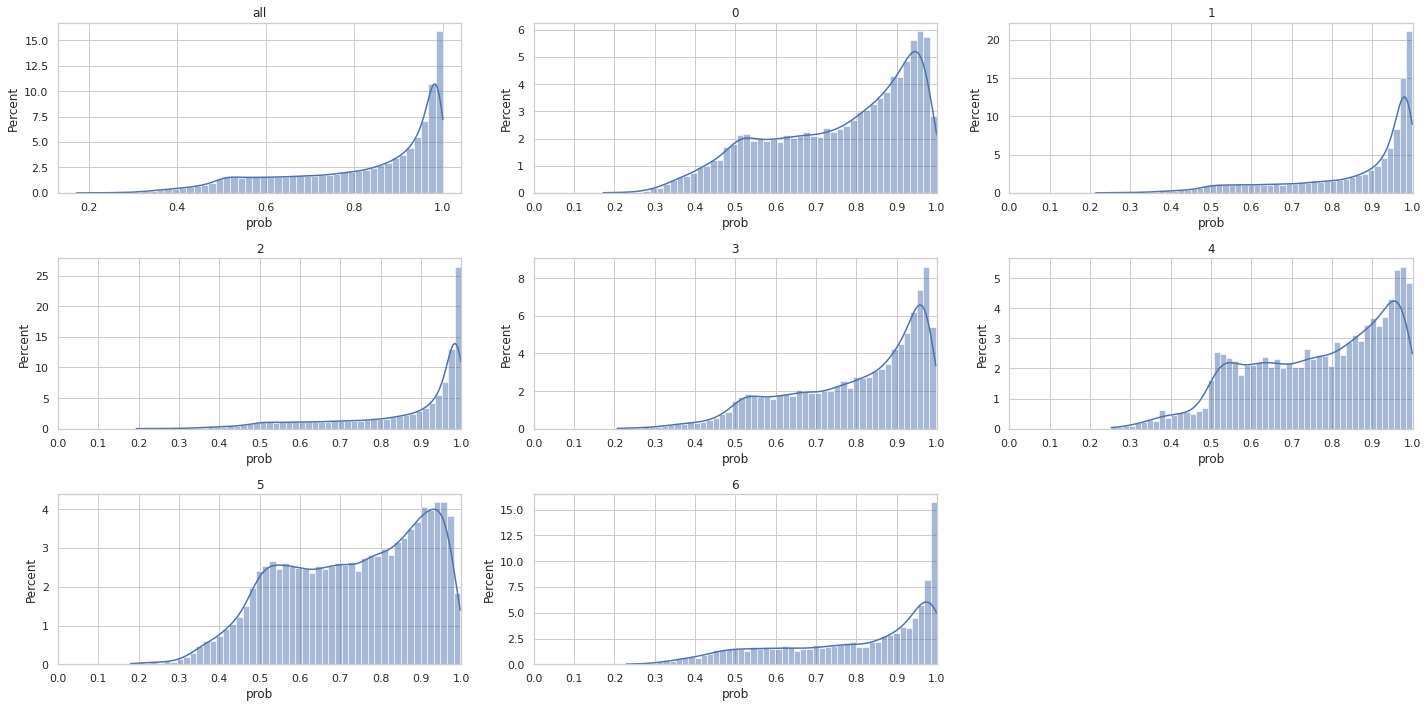

In [21]:
fig = plt.figure(figsize=(20, 10))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1, palette=None)
sns.set_style("whitegrid")
plt.subplot(331)
plt.title("all")
sns.histplot(out_decals_pred.query("redshift > 0.075 and redshift < 0.15 and petro_mag < 17.77").prob, stat="percent", label="DECaLS", bins=50, kde=True)
for i in range(7):
    plt.subplot(3, 3, i + 2)
    plt.title(i)
    sns.histplot(out_decals_pred.query("redshift > 0.075 and redshift < 0.15 and petro_mag < 17.77 and label == %d" % i).prob, stat="percent", label="DECaLS", bins=50, kde=True)
    plt.xlim(0, 1)
    plt.xticks(np.arange(0, 1.001, 0.1))
plt.tight_layout()
plt.show()

In [22]:
in_z = np.array(decals_50p.query("redshift_x < 0.15 and redshift_x > 0.001 and petro_mag<17.77").redshift_x)
out_z = np.array(out_decals_pred.query("redshift < 0.15 and redshift > 0.001 and petro_mag<17.77").redshift)
in_mag = np.array(decals_50p.query("redshift_x < 0.15 and redshift_x > 0.001 and petro_mag<17.77").petro_mag)
out_mag = np.array(out_decals_pred.query("redshift < 0.15 and redshift > 0.001 and petro_mag<17.77").petro_mag)

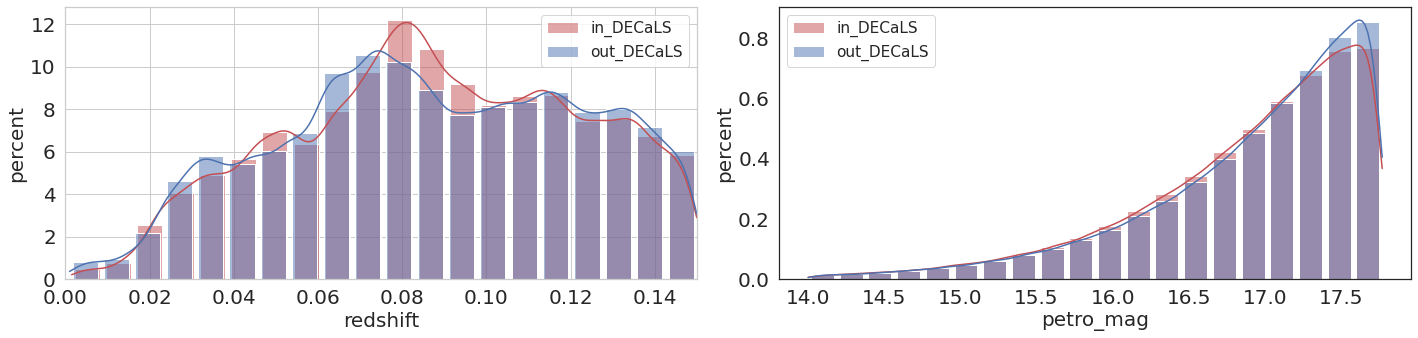

In [23]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("white")
sns.histplot(in_z, stat="density", bins=20, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(out_z,stat="density", bins=20, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("redshift", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.xlim((0, 0.15))

plt.subplot(122)
sns.histplot(in_mag, stat="density", bins=20, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(out_mag, stat="density", bins=20, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("petro_mag", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# .pvalue>0.05
print(ks_2samp(out_z, in_z))
print(ks_2samp(in_mag, out_mag))

KstestResult(statistic=0.03034494454004677, pvalue=1.0215006437654696e-99)
KstestResult(statistic=0.027782691310320407, pvalue=1.1784449682270035e-83)


In [25]:
from sklearn.utils import shuffle
in_test = decals_max_distribution.query("redshift_x < 0.15 and redshift_x > 0.001 and petro_mag<17.77").copy()
in_test = in_test.rename(columns={"redshift_x": "redshift"})
out_test = out_decals_pred.query("redshift < 0.15 and redshift > 0.001 and petro_mag<17.77").copy()
def cut(in_test, out_test, target, bins=20):
    bin = []
    if target=="redshift":
        step = 0.15 / bins
        for i in range(bins):
            if i == 0:
                bin.append([0.001, 0.001+(i+1)*step])
            else:
                bin.append([0.001+i*step, 0.001+(i+1)*step])
    elif target == "petro_mag":
        step = 3.77 / bins
        for i in range(bins):
            if i == 0:
                bin.append([14, 14+(i+1)*step])
            else:
                bin.append([14+i*step, 14+(i+1)*step])
    def control(in_test, out_test, bin):
        df_in = pd.DataFrame(columns=in_test.columns)
        df_out = pd.DataFrame(columns=out_test.columns)
        for i in range(len(bin)):
            bin_1 = in_test.query("%s > %f and %s < %f" %(target, bin[i][0], target, bin[i][1]))
            bin_2 = out_test.query("%s > %f and %s < %f" %(target, bin[i][0], target, bin[i][1]))
            if len(bin_1) < len(bin_2):
                frac = len(bin_1)/len(bin_2)
                bin_2 = bin_2.sample(frac=frac)
                df_in = pd.concat([df_in, bin_1])
                df_out = pd.concat([df_out, bin_2])
            else:
                frac = len(bin_2)/len(bin_1)
                bin_1 = bin_1.sample(frac=frac)
                df_in = pd.concat([df_in, bin_1])
                df_out = pd.concat([df_out, bin_2])
        return df_in.reset_index(drop=True), df_out.reset_index(drop=True)
    return control(in_test, out_test, bin)
decals_ctrled, out_decals_ctrled = cut(in_test, out_test, "petro_mag", bins=30)   # 分别对 z 和 mag 进行 cut
decals_ctrled, out_decals_ctrled = cut(decals_ctrled, out_decals_ctrled, "redshift", bins=40)

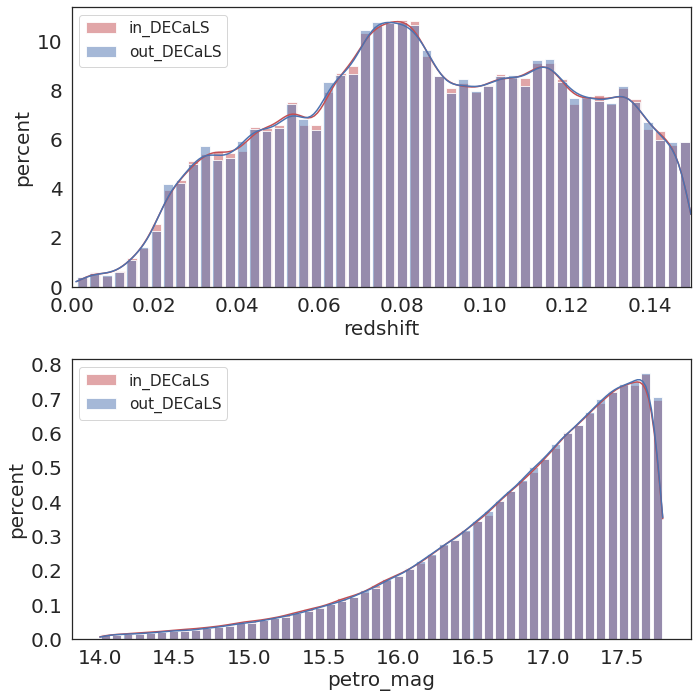

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("white")
sns.histplot(decals_ctrled.redshift, stat="density", bins=50, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(out_decals_ctrled.redshift, stat="density", bins=50, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("redshift", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.xlim((0, 0.15))

plt.subplot(212)
sns.histplot(decals_ctrled.petro_mag, stat="density", bins=50, shrink=0.8, kde=True, color="r", label="in_DECaLS")
sns.histplot(out_decals_ctrled.petro_mag, stat="density", bins=50, shrink=0.8, kde=True, label="out_DECaLS")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("petro_mag", fontsize=20)
plt.ylabel("percent", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# .pvalue>0.05
print(ks_2samp(decals_ctrled.redshift, out_decals_ctrled.redshift))
print(ks_2samp(decals_ctrled.petro_mag, out_decals_ctrled.petro_mag))

KstestResult(statistic=0.0015769669809326536, pvalue=0.9298656429658525)
KstestResult(statistic=0.005339703208895291, pvalue=0.0023473039549904086)


In [28]:
# def show(rg, ax, catalog_1, catalog_2, label_1, label_2, prob):
#     l, r = rg
#     if l <0.001:
#         l = 0.001
#     try:
#         catalog_1 = catalog_1.query("petro_mag < 17.77 and redshift < %f and redshift > %f" % (r,l))
#         catalog_2 = catalog_2.query("petro_mag < 17.77 and redshift < %f and redshift > %f and prob > %f" % (r, l, prob))
#     except:
#         catalog_1 = catalog_1.query("petro_mag < 17.77 and redshift_x < %f and redshift_x > %f" % (r,l))
#         catalog_2 = catalog_2.query("petro_mag < 17.77 and redshift < %f and redshift > %f and prob > %f" % (r, l, prob))
#     percent_1, percent_2 = calculate_percent(catalog_1), calculate_percent(catalog_2)
#     width = 0.4
#     x = np.arange(len(labels))
#     ax.bar(x - width/2, percent_1, width, label=label_1)
#     ax.bar(x + width/2, percent_2, width, label=label_2)
#     ax.set_xticks(x)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)

In [29]:
def cal_error(num, sum, k=3):
    return k * (math.sqrt((math.sqrt(num)/sum)**2 + (num*math.sqrt(sum)/(sum*sum))**2))

In [30]:
decals_ctrled

,petro_mag,redshift,label,ra,dec,redshift_y,merging_merger_fraction,merging_major_disturbance_fraction,merging_minor_disturbance_fraction,merging_none_fraction,smooth_or_featured_artifact_fraction,smooth_or_featured_featured_or_disk_fraction,smooth_or_featured_smooth_fraction,how_rounded_round_fraction,how_rounded_in_between_fraction,how_rounded_cigar_shaped_fraction,disk_edge_on_yes_fraction,disk_edge_on_no_fraction,bar_no_fraction,bar_strong_fraction
0,14.005164,0.003913,5,191.119890,0.468073,0.003913,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,14.029266,0.003230,6,191.943848,4.336023,0.003223,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,14.049812,0.002464,5,175.461113,15.973828,0.002464,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,14.033956,0.002309,2,186.201535,18.195101,0.002309,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,14.190752,0.001596,0,191.106499,3.525200,0.001596,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236525,17.683256,0.147767,1,153.857980,15.392541,0.147767,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
236526,17.742887,0.149770,2,138.650934,13.066947,0.149770,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
236527,17.705187,0.147381,2,148.446804,14.892019,0.147381,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
236528,17.725903,0.149971,2,156.737177,16.331404,0.149971,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [31]:
out_decals_ctrled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236530 entries, 0 to 236529
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   petro_mag  236530 non-null  float64
 1   redshift   236530 non-null  float64
 2   ra         236530 non-null  float64
 3   dec        236530 non-null  float64
 4   loc        236530 non-null  object 
 5   label      236530 non-null  object 
 6   prob       236530 non-null  float64
dtypes: float64(5), object(2)
memory usage: 12.6+ MB


In [32]:
def display(data, out_s):
    a = []
    for i in range(len(out_s)):
        b = []
        deleted = np.delete(data, obj=i, axis=1)
        out_s_copy = out_s.copy()
        poped = out_s_copy.pop(i)
        focus = data[:, i]
        for j in range(len(out_s)-1):
            b.append(((deleted[i, j] / deleted[:, j].sum()) * out_s_copy[j]))
        a.append(np.array(b).sum() + poped - (1 - (focus[i]/focus.sum())) * out_s[i])
    return np.array(a)

import pickle
with open("/data/renhaoye/decals_2022/trained_model/x_ception-LR_0.0001-LS_focal_loss-CLS_7-BSZ_32-OPT_AdamW-BEST_2/cfm/epoch_5_test.dat", "rb") as r:
    data = pickle.load(r)

def get_percent(data):
    sum = 0
    for i in data:
        sum += i
    for i in range(len(data)):
        data[i] = data[i] / sum
    return data

class predicted():
    def __init__(self, in_decals, out_decals, class_num, k, cfm):
        self.in_decals = in_decals
        self.out_decals = out_decals
        self.in_sum = len(self.in_decals)
        self.out_sum = len(self.out_decals)
        self.class_num = class_num
        self.k = k
        self.cfm = cfm

    def __call__(self, *args, **kwargs):
        def get_num(self, dst: pd.DataFrame):
            out = []
            for i in range(self.class_num):
                out.append(len(dst.query("label == %d" % i)))
            return out
        def get_error(self, num, sum, k):
            error = []
            for i in range(self.class_num):
                error.append(cal_error(num[i], sum, k))
            return error
        self.in_percent = calculate_percent(self.in_decals) # DECaLS的各类别比重
        self.out_percent = calculate_percent(self.out_decals) # 非DECaLS的各类别比重
        self.in_num = get_num(self, self.in_decals) # DECaLS的各类别数量
        self.out_num = get_num(self, self.out_decals) # 非DECaLS的各类别数量，没有代入精确率和召回率
        self.in_error = get_error(self, self.in_num, self.in_sum, self.k) # DECaLS的泊松分布误差，没有代入精确率和召回率
        self.out_error = get_error(self, self.out_num, self.out_sum, self.k) # 非DECaLS的泊松分布误差，没有代入精确率和召回率
        self.modified_out_num = display(self.cfm, self.out_num) # 非DECaLS的泊松分布误差，代入精确率和召回率
        self.modified_out_percent = get_percent(self.modified_out_num.copy())
        self.modified_out_error = get_error(self, self.modified_out_num, self.out_sum, self.k) # 非DECaLS的泊松分布误差，代入精确率和召回率

def show_percent_contrast(p, width, labels, remove, modified: bool):
    x = np.arange(len(labels))
    in_percent = p.in_percent
    in_error = p.in_error
    if modified:
        out_percent = p.modified_out_percent
        out_error = p.modified_out_error
    else:
        out_percent = p.out_percent
        out_error = p.out_error
    fig, ax = plt.subplots(figsize=(15, 7))
    print(len(in_percent))
    ax.bar(x - width/2, in_percent, width, label='in_decals')
    ax.bar(x + width/2, out_percent, width, label='out_decals')
    ax.set_ylabel('Percent', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    for a,b in zip(x, in_percent): ##控制标签位置
        plt.text(a-width/2,b,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
        if b not in remove:
            temp = in_error[a]
            y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
            plt.errorbar(x=a-width/2, y=b, yerr=y_error,
                         color="black", capsize=3,linestyle="None", marker="s",
                         markersize=1, mfc="black", mec="black")
    for a,b in zip(x, out_percent): ##控制标签位置
        plt.text(a+width/2,b,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
        if b not in remove:
            temp = out_error[a]
            y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
            plt.errorbar(x=a+width/2, y=b, yerr=y_error,
                         color="black", capsize=3,linestyle="None", marker="s",
                         markersize=1, mfc="black", mec="black")
    ax.legend(fontsize=20)
    # plt.title(prob)
    plt.ylim(0, 0.5)
    plt.show()

7


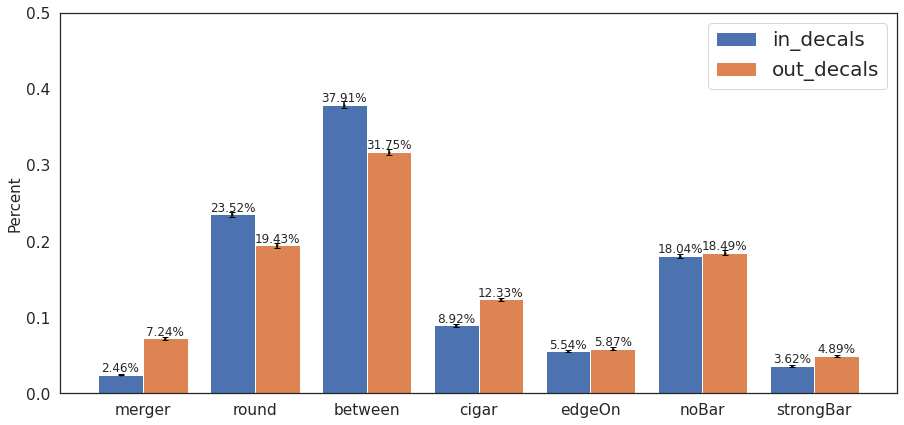

In [33]:
ll, rr = 0.001, 0.15
labels = ["merger", "round", "between", "cigar", "edgeOn", "noBar", "strongBar"]
# plt.style.use("seaborn-white")
# sns.set_style("white")
p = predicted(decals_ctrled.query('redshift > %f and redshift < %f and petro_mag < 17.77' % (ll, rr)),
              out_decals_ctrled.query('redshift > %f and redshift < %f and prob > %f  and petro_mag < 17.77' % (ll, rr, 0.5001)), 7, 3, data)
p()
show_percent_contrast(p, 0.4, labels, [], True)

In [108]:
p.in_num, list(p.modified_out_num.astype(int))

([5811, 55632, 89622, 21042, 13144, 42604, 8552],
 [15940, 42570, 69910, 27165, 13002, 40809, 10781])

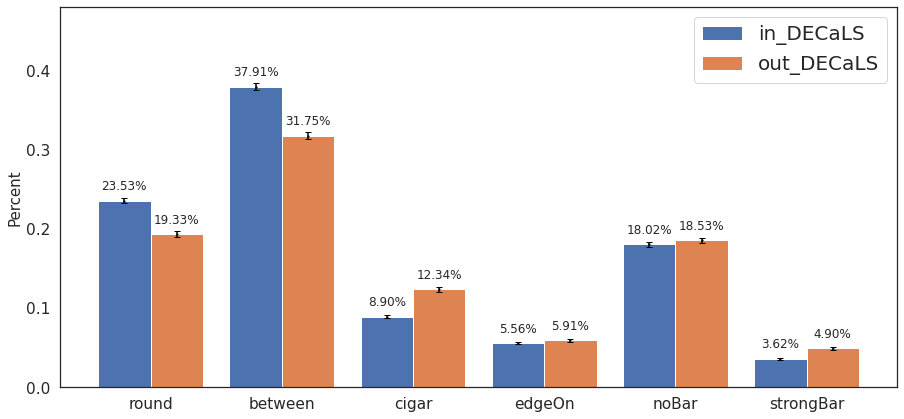

In [114]:
ll, rr = 0.001, 0.15
# indecals = [5811, 55632, 89622, 21042, 13144, 42604, 8552]
# outdecals = [15940, 42570, 69910, 27165, 13002, 40809, 10781]
innum = p.in_num[1:]
outnum = list(p.modified_out_num.astype(int))[1:]
inpercent = p.in_percent[1:]
outpercent = p.modified_out_percent[1:]

labels=["round", "between", "cigar", "edgeOn", "noBar", "strongBar"]
width = 0.4
sns.set_style("white")
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - width/2, inpercent, width, label='in_DECaLS')
ax.bar(x + width/2, outpercent, width, label='out_DECaLS')
ax.set_ylabel('Percent', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x, inpercent): ##控制标签位置
    plt.text(a-width/2, b + 0.01, '%.2f%%' % (b * 100), ha='center', va='bottom', fontsize=12)
    if b !=0 :
        sum = np.array(innum).sum()
        l_s = np.array(innum)[a]
        temp = cal_error(l_s, sum, 3)
        y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
        plt.errorbar(x=a-width/2, y=b, yerr=y_error,
                     color="black", capsize=3,linestyle="None", marker="s",
                     markersize=1, mfc="black", mec="black")
for a,b in zip(x, outpercent): ##控制标签位置
    plt.text(a+width/2, b + 0.01,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=12)
    if b !=0 :
        sum = np.array(outnum).sum()
        l_s = np.array(outnum)[a]
        temp = cal_error(l_s, sum, 3)
        y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
        plt.errorbar(x=a+width/2, y=b, yerr=y_error,
                     color="black", capsize=3,linestyle="None", marker="s",
                     markersize=1, mfc="black", mec="black")
ax.legend(fontsize=20)
# plt.title(str(ll)+"<z<"+str(rr))
plt.ylim((0,0.48))
plt.show()

In [29]:
test = pd.read_table("/data/renhaoye/decals_2022/out_decals_prob7.txt", sep="\s+")
test = match(MGS, test)
test.drop(["new_ra", "new_dec"], axis=1, inplace=True)
probs = test.drop(["loc"], axis=1).query("redshift > 0.001 and redshift < 0.15 and petro_mag < 17.77")

In [38]:
prob7 = np.array(probs[["prob_0", "prob_1", "prob_2", "prob_3", "prob_4", "prob_5", "prob_6"]].dropna(axis=0, how="any"))
prob7_sum = np.sum(prob7, axis=0, keepdims=True)
label_sum = np.sum(prob7_sum, axis=1)

In [ ]:
p.ou

[166313  13161  42627   8580] 230681 [171832  15739  48129  12522] 248222
elliptical 0.70%
edgeOn 0.15%
noBar 0.29%
strongBar 0.12%

elliptical 0.65%
edgeOn 0.16%
noBar 0.29%
strongBar 0.14%


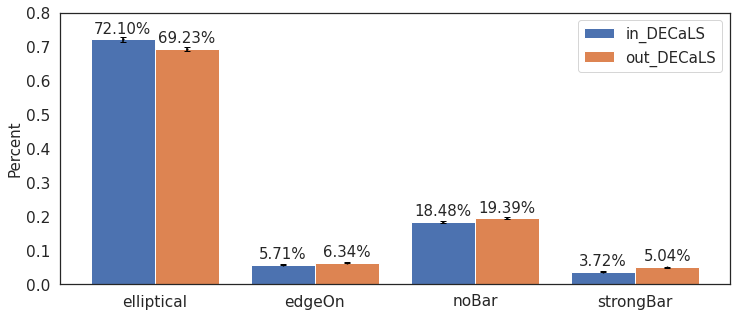

In [44]:
here1 = decals_ctrled.copy()
here2 = probs.copy()
ll, rr = 0.001, 0.15
# ll, rr = 0.001, 0.05
# ll, rr = 0.05, 0.10
# ll, rr = 0.1, 0.15
# ll, rr = 0.025, 0.075
here1 = here1.query("redshift > %f and redshift < %f and petro_mag < 17.77" % (ll, rr))
here2 = here2.query("redshift > %f and redshift < %f and petro_mag < 17.77 and prob > 0.5001" % (ll, rr))
in_sum = np.array((len(here1.query("label == 0")), len(here1.query("label == 1")), len(here1.query("label == 2")), len(here1.query("label == 3")), len(here1.query("label == 4")), len(here1.query("label == 5")), len(here1.query("label == 6"))))
out_sum = np.array((len(here2.query("label == 0")), len(here2.query("label == 1")), len(here2.query("label == 2")), len(here2.query("label == 3")), len(here2.query("label == 4")), len(here2.query("label == 5")), len(here2.query("label == 6"))))
# out_sum = match_num(prob7_sum[0], out_sum)
out_sum = display(data, list(out_sum))
# in_sum[[0]] = 0
# out_sum[[0]] = 0
# in_sum = np.array([0,55558+89655+21100, 0, 0,13161,42627, 8580])
# out_sum = np.array([0,51748+86302+33782, 0, 0, 15739, 48129, 12522])
in_sum = np.array([55558+89655+21100,13161,42627, 8580])
out_sum = np.array([51748+86302+33782, 15739, 48129, 12522])
labels=["elliptical", "edgeOn", "noBar", "strongBar"]
# temp_1 = in_sum[]
in_sum_p = calculate_percent(num=list(in_sum))
out_sum_p = calculate_percent(num=list(out_sum))
width = 0.4
sns.set_style("white")
x = np.arange(len(in_sum_p))
print(in_sum, in_sum.sum(), out_sum, out_sum.sum())
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width/2, in_sum_p, width, label='in_DECaLS')
ax.bar(x + width/2, out_sum_p, width, label='out_DECaLS')
ax.set_ylabel('Percent', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
for a,b in zip(x, in_sum_p): ##控制标签位置
    plt.text(a-width/2, b + 0.01, '%.2f%%' % (b * 100), ha='center', va='bottom', fontsize=15)
    if b !=0 :
        sum = in_sum.sum()
        l_s = in_sum[a]
        temp = cal_error(l_s, sum, 3)
        print(labels[a], '%.2f%%' % (temp * 100))
        y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
        plt.errorbar(x=a-width/2, y=b, yerr=y_error,
                     color="black", capsize=3,linestyle="None", marker="s",
                     markersize=1, mfc="black", mec="black")
print()
for a,b in zip(x, out_sum_p): ##控制标签位置
    plt.text(a+width/2, b + 0.01,'%.2f%%'% (b * 100),ha = 'center',va = 'bottom',fontsize=15)
    if b !=0 :
        sum = out_sum.sum()
        l_s = out_sum[a]
        temp = cal_error(l_s, sum, 3)
        print(labels[a], '%.2f%%' % (temp * 100))
        y_error = [[b] if (b - temp) < 0 else [temp], [temp]]
        plt.errorbar(x=a+width/2, y=b, yerr=y_error,
                     color="black", capsize=3,linestyle="None", marker="s",
                     markersize=1, mfc="black", mec="black")
ax.legend(fontsize=15)
# plt.title(str(ll)+"<z<"+str(rr))
plt.ylim((0,0.8))
plt.show()

In [29]:
here1 = decals_ctrled.copy()
here2 = probs.copy()

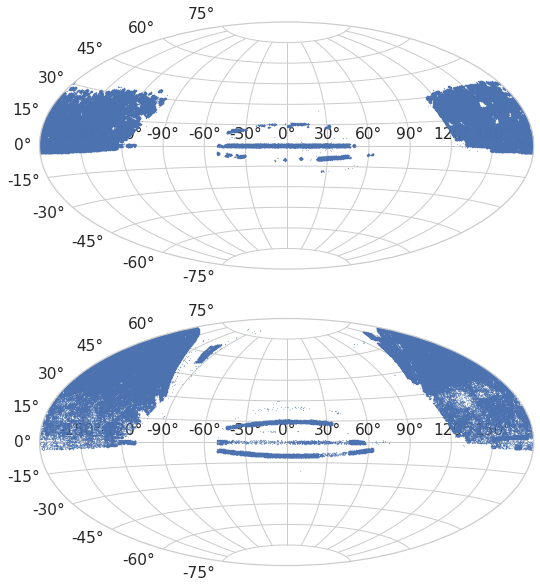

In [30]:
sc = SkyCoord(ra=here1.ra*u.degree, dec=here1.dec*u.degree)
sc2 = SkyCoord(ra=here2.ra*u.degree, dec=here2.dec*u.degree)
plt.figure(figsize=(10, 10))
plt.subplot(211, projection="aitoff")
plt.scatter(sc.ra.wrap_at(180*u.deg).radian, sc.dec.radian, marker=".", s=0.1)
plt.subplot(212, projection="aitoff")
plt.scatter(sc2.ra.wrap_at(180*u.deg).radian, sc2.dec.radian, marker=".", s=0.1)
plt.show()

In [31]:
def transf_galactic(df):
    sc = SkyCoord(ra=df.ra*u.degree, dec=df.dec*u.degree, unit="deg")
    lb = np.array((np.array(sc.galactic.l.wrap_at(180*u.deg).radian), np.array(sc.galactic.b.radian)))
    return pd.DataFrame(lb.T, columns=["l", "b"])

In [32]:
# .query("label == 0")
lb_in = transf_galactic(here1.query("label == 0"))
lb_out = transf_galactic(here2.query("label == 0"))

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(121, projection="aitoff")
plt.title("DECaLS")
plt.scatter(lb_in.l, lb_in.b, marker=".", s=0.1)
plt.subplot(122, projection="aitoff")
plt.title("BASS+MzLS")
plt.scatter(lb_out.l, lb_out.b, marker=".", s=0.1)
plt.show()

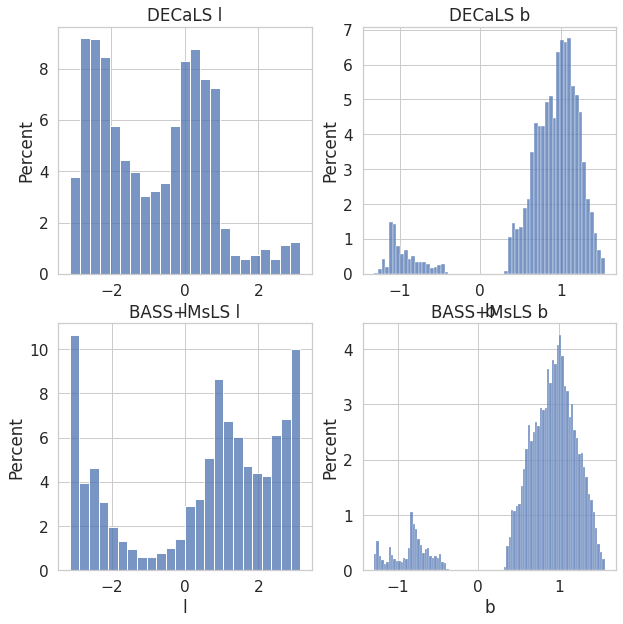

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("DECaLS l")
sns.histplot(lb_in.l, stat="percent")
plt.subplot(222)
plt.title("DECaLS b")
sns.histplot(lb_in.b, stat="percent")

plt.subplot(223)
plt.title("BASS+MsLS l")
sns.histplot(lb_out.l, stat="percent")
plt.subplot(224)
plt.title("BASS+MsLS b")
sns.histplot(lb_out.b, stat="percent")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

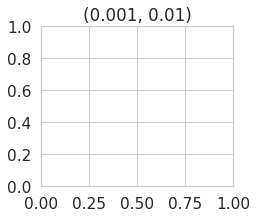

In [35]:
plt.figure(figsize=(20, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    if i == 0:
        ax.set_title((0.001, (i+1)*0.01))
    else:
        ax.set_title((i*0.01, (i+1)*0.01))
    show((i*0.01, (i+1)*0.01), ax, decals_max_distribution, out_decals_pred, "in_DECaLS", "out_DECaLS", prob=0.8001)
plt.tight_layout()
plt.show()

In [ ]:
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError
def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)

In [ ]:
DATA_PATH = "/data/renhaoye/decals_2022/out_decals/scaled/"
with open("/data/renhaoye/decals_2022/out_decals_prob.txt", "r") as r:
    input = r.readlines()[1:]
    input = [x.split(" ") for x in input]

In [ ]:
plt.figure(figsize=(20, 20))
begin = 300303
t = {0:"merger", 1:"round", 2:"between", 3:"cigar", 4:"edgeOn", 5:"noBar", 6:"strongBar"}
for i in range(begin, begin + 100):
    ax = plt.subplot(10, 10, i + 1 - begin)
    img = load_img(DATA_PATH + input[i][2])
    plt.imshow(chw2hwc(img))
    plt.xticks([])
    plt.yticks([])
    a, b = input[i][-1].split("\n")[0].split(".")
    prob = a + "." + b[:2]
    ax.set_title(t[int(input[i][-2])] + ":" + prob)
plt.tight_layout()
plt.show()